# GW self-energy of a 2D square lattice Hubbard model

In [1]:
import sys, os
import numpy as np
from triqs.plot.mpl_interface import plt,oplot

from h5 import HDFArchive
from triqs.atom_diag import *

from triqs.gf import *
from triqs.operators import c, c_dag, n, dagger
from itertools import product


from triqs.lattice.tight_binding import TBLattice
from triqs.lattice.utils import k_space_path

from triqs_tprf.lattice import lattice_dyson_g0_wk, lattice_dyson_g_wk, lattice_dyson_g0_fk, dynamical_screened_interaction_W, lattice_dyson_g_fk
from triqs_tprf.gw import bubble_PI_wk, gw_sigma, lindhard_chi00, g0w_sigma

from triqs_Nevanlinna import Solver

from triqs_maxent import *

import seaborn as sns
import scienceplots
plt.style.use(['science','notebook'])
sns.set_palette('muted')

Starting serial run at: 2023-02-09 16:24:09.422651


## Setup simple two orbital 2D Hubbard model on square lattice

In [2]:
n_orb = 1

loc = np.zeros((n_orb,n_orb))
for i in range(n_orb):
    for j in range(n_orb):
        if i != 0 and i==j:
            loc[i,j] = -0.3
        if j > i or j < i:
            loc[i,j] = -0.5

t = -1.0 * np.eye(n_orb)   #nearest neighbor hopping
tp = 0.1 * np.eye(n_orb)    #next nearest neighbor hopping

hop= {  (0,0)  :  loc,
        (1,0)  :  t,       
        (-1,0) :  t,     
        (0,1)  :  t,
        (0,-1) :  t,
        (1,1)  :  tp,
        (-1,-1):  tp,
        (1,-1) :  tp,
        (-1,1) :  tp}

TB = TBLattice(units = [(1, 0, 0) , (0, 1, 0)], hoppings = hop, orbital_positions= [(0., 0., 0.)]*n_orb)

### plot dispersion along high-symmetry lines

In [22]:
n_pts = 101
G = np.array([ 0.00,  0.00,  0.00])
M = np.array([0.5, 0.5, 0.0])
X = np.array([0.5, 0.0, 0.0])
R = np.array([0.5, 0.5, 0.5])
paths = [(R, G), (G, X), (X, M), (M, G)]

kvecs, k  = k_space_path(paths, num=n_pts, bz=TB.bz)
    
e_mat = TB.fourier(kvecs)
e_val = TB.dispersion(kvecs)
eps_k = {'k': k, 'K': np.concatenate(([0],k[n_pts-1::n_pts])), 'eval': e_val, 'emat' : e_mat}

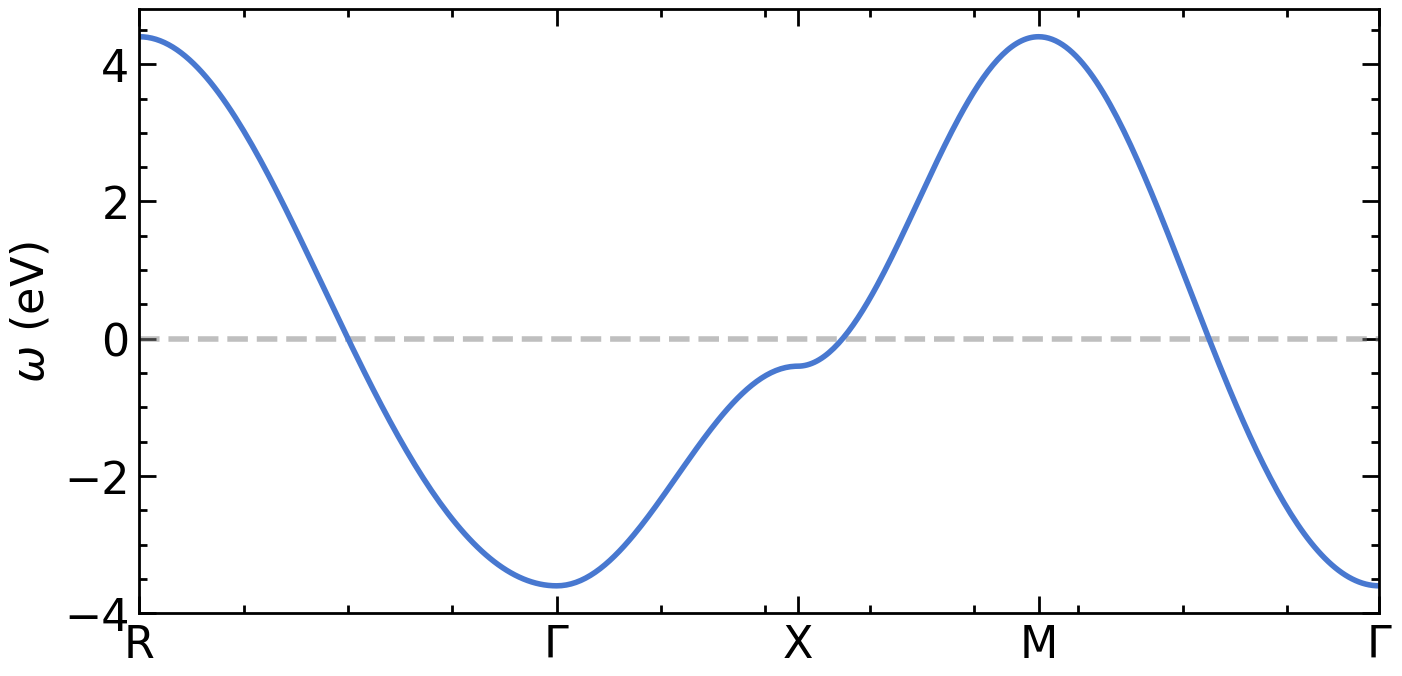

In [23]:
fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=200, squeeze=False)
ax = ax.reshape(-1)

for band in range(eps_k['eval'].shape[1]):
    ax[0].plot(eps_k['k'], eps_k['eval'][:,band].real, color='C0', zorder=2.5)

ax[0].axhline(y=0,zorder=2,color='gray',alpha=0.5,ls='--')
ax[0].set_xticks(eps_k['K'])
ax[0].set_xticklabels([r'R', '$\Gamma$', 'X', 'M', r'$\Gamma$'])
ax[0].set_xlim([eps_k['K'].min(), eps_k['K'].max()])
ax[0].set_ylabel(r'$\omega$ (eV)')

plt.show()

## GW in imaginary time

In [5]:
k_grid = (30,30,1)
k_mesh = TB.get_kmesh(n_k = k_grid)
e_k = TB.fourier(k_mesh)
eps_k = TB.dispersion(k_mesh)
mu = 0.

beta = 10
n_iw = 400
iw_mesh = MeshImFreq(beta=beta, S='Fermion', n_max=n_iw)
G0_iwk = lattice_dyson_g0_wk(mu=mu, e_k=e_k, mesh=iw_mesh)

### setup bare interaction

In [6]:
def construct_U_kan(n_orb, U, J, Up=None, Jc=None):
    
    orb_range = range(0, n_orb)
    U_kan = np.zeros((n_orb, n_orb, n_orb, n_orb))
    
    if not Up:
        Up = U-2*J
    if not Jc:
        Jc = J
        
    for i,j,k,l in product(orb_range, orb_range, orb_range, orb_range):
        if i == j == k == l: # Uiiii
            U_kan[i, j, k, l] = U
        elif i == k and j == l: # Uijij
            U_kan[i, j, k, l] = Up
        elif i == l and j == k: # Uijji
            U_kan[i, j, k, l] = J
        elif i == j and k ==l: # Uiijj
            U_kan[i, j, k, l] = Jc
    return U_kan

In [7]:
U=1
Up=0.2
J=0.4
V_k = Gf(mesh=k_mesh, target_shape=[n_orb*1]*4)

V_bare = np.zeros((n_orb,n_orb,n_orb,n_orb))
# simple onsite intra orbital Coulomb repulsion
for i in range(n_orb):
    for j in range(n_orb):
        if i == j:
            V_bare[i,i,j,j] = U
        else:
            V_bare[i,i,j,j] = Up

V_bare = construct_U_kan(n_orb=n_orb,U=U,J=J,Up=Up)


V_k.data[:] = V_bare

### Run one GW loop

In [8]:
print('--> pi_bubble')
PI_iwk = bubble_PI_wk(G0_iwk)

print('--> screened_interaction_W')
Wr_iwk = dynamical_screened_interaction_W(PI_iwk, V_k)

print('--> gw_self_energy')
Σ_iwk = gw_sigma(Wr_iwk, G0_iwk)

print('--> lattice_dyson_g_wk')
G_wk = lattice_dyson_g_wk(mu, e_k, Σ_iwk)

Σ_Γ_iw = Σ_iwk[:, Idx(0,0,0)] 
Σ_X_iw = Σ_iwk[:, Idx(k_grid[1]-1,0,0)] 

--> pi_bubble
--> screened_interaction_W
--> gw_self_energy
--> lattice_dyson_g_wk


### Plot results

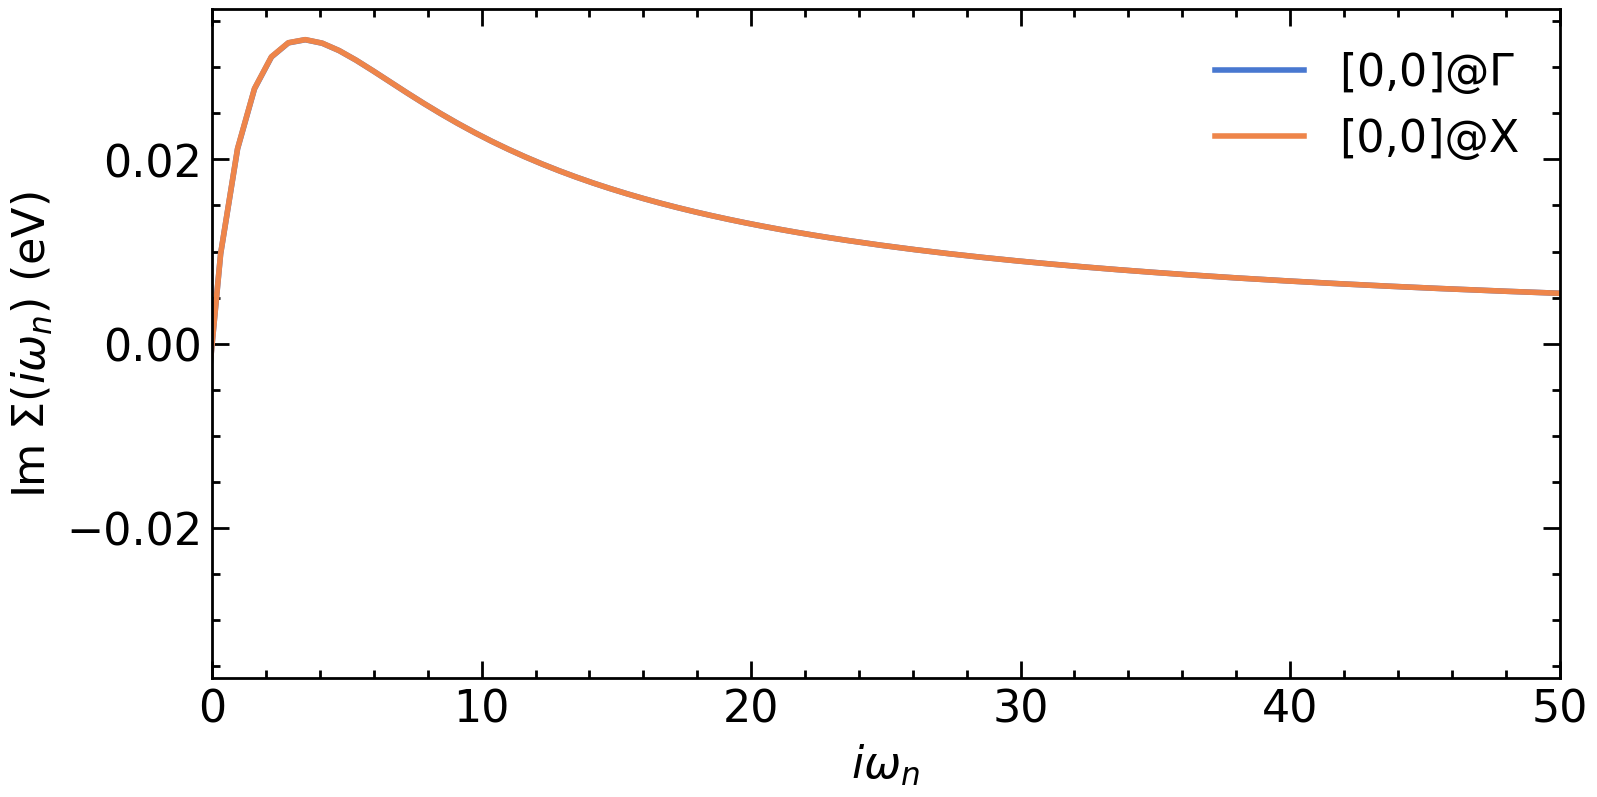

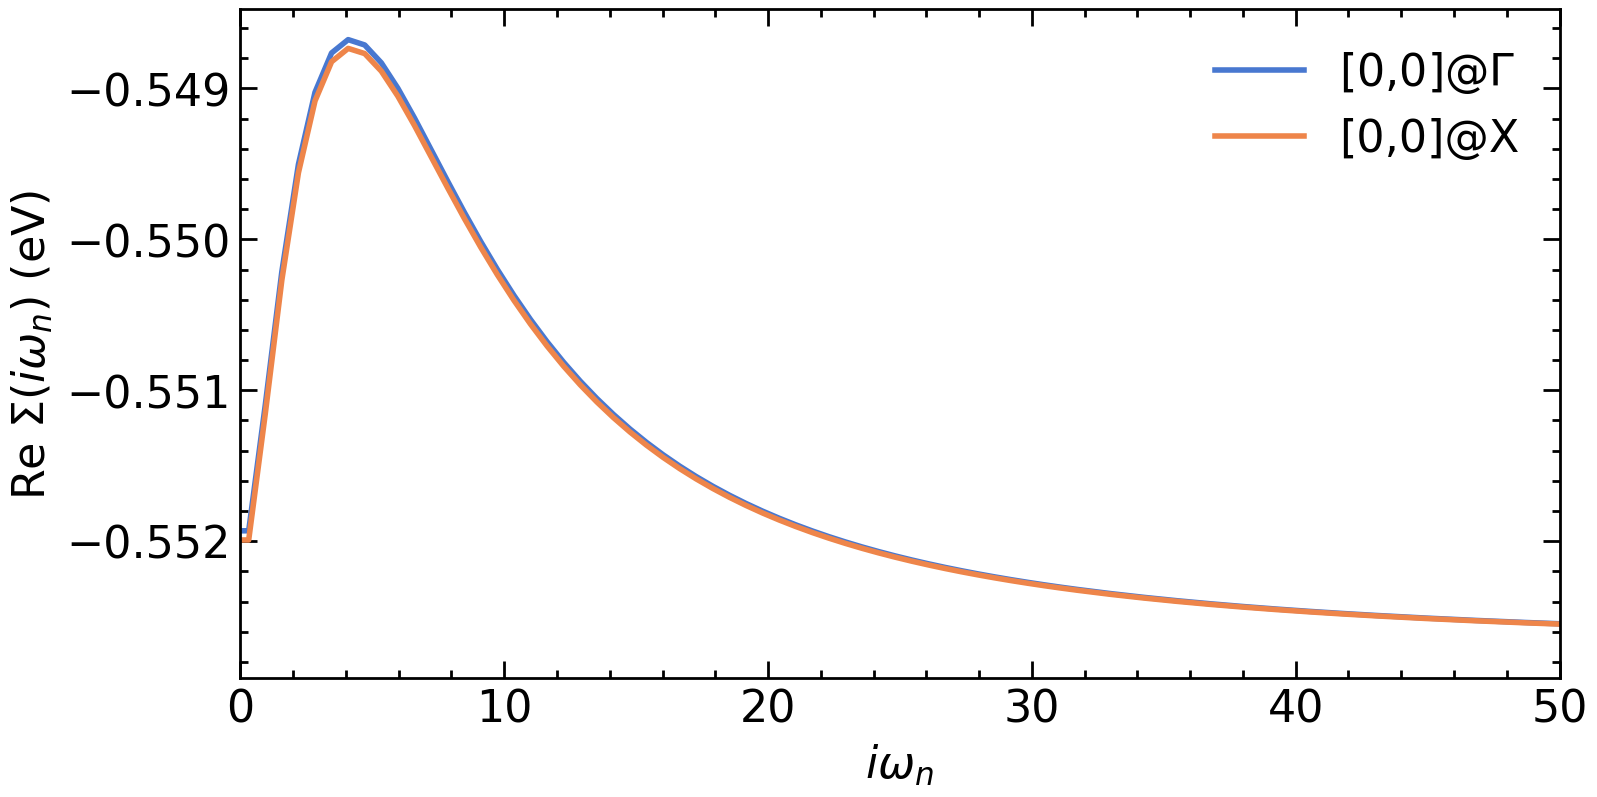

In [25]:
fig, ax = plt.subplots(n_orb, n_orb, figsize=(8*n_orb,4*n_orb), dpi=200, squeeze=False,sharex=True)

shp = Σ_Γ_iw.target_shape
for i in range(n_orb):
    for j in range(n_orb):
        ax[i,j].oplot(Σ_Γ_iw[i,j].imag, label=f'[{i},{j}]@$\Gamma$')
        ax[i,j].oplot(Σ_X_iw[i,j].imag, label=f'[{i},{j}]@X')

        ax[i,j].set_xlim(0,50)
        
        if i == shp[0]-1:
            ax[i,j].set_xlabel(r'$i\omega_n$')
        else:
            ax[i,j].set_xlabel(r'')
        if j == 0:
            ax[i,j].set_ylabel(r'Im $\Sigma (i\omega_n)$ (eV)')
        else:
            ax[i,j].set_ylabel(r'')

plt.tight_layout(pad=0.4, w_pad=0.1, h_pad=0.4)
plt.show()

fig, ax = plt.subplots(n_orb, n_orb, figsize=(8*n_orb,4*n_orb), dpi=200, squeeze=False,sharex=True)

for i in range(n_orb):
    for j in range(n_orb):
        ax[i,j].oplot(Σ_Γ_iw[i,j].real, label=f'[{i},{j}]@$\Gamma$')
        ax[i,j].oplot(Σ_X_iw[i,j].real, label=f'[{i},{j}]@X')

        ax[i,j].set_xlim(0,50)
        
        if i == shp[0]-1:
            ax[i,j].set_xlabel(r'$i\omega_n$')
        else:
            ax[i,j].set_xlabel(r'')
        if j == 0:
            ax[i,j].set_ylabel(r'Re $\Sigma (i\omega_n)$ (eV)')
        else:
            ax[i,j].set_ylabel(r'')

plt.tight_layout(pad=0.4, w_pad=0.1, h_pad=0.4)
plt.show()

## GW on real frequency axis

In [10]:
# make sure 0 is not in the mesh! Divergence for q=[0,0,0]
# no large freq mesh is needed. kmesh critical for convergence here
n_w = 100
delta = 0.1
GW_window = (-15, 15)
w_mesh = MeshReFreq(window=GW_window, n_w=n_w)


G0_wk = lattice_dyson_g0_fk(mu=mu, e_k=e_k, mesh=w_mesh, delta=delta)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [11]:
print('--> pi_bubble')
PI_wk = lindhard_chi00(e_k=e_k, mesh=w_mesh, beta=beta, mu=mu, delta=delta)

print('--> screened_interaction_W')
Wr_wk = dynamical_screened_interaction_W(PI_wk, V_k)

print('--> gw_self_energy')
Σ_wk = g0w_sigma(mu=mu, beta=beta, e_k=e_k, W_fk=Wr_wk, v_k=V_k, delta=delta)

print('--> lattice_dyson_g_wk')
g_fk = lattice_dyson_g_fk(mu, e_k, Σ_wk, delta)

Σ_Γ_w = Σ_wk[:, Idx(0,0,0)] 
Σ_X_w = Σ_wk[:, Idx(k_grid[1]-1,0,0)] 

--> pi_bubble
--> screened_interaction_W
--> gw_self_energy
--> lattice_dyson_g_wk


## Analytic continuation

### Nevanlinna

In [12]:
# setup Nevanlinna kernel solver
solver = Solver(kernel="kernels::CARATHEODORY")

solver.solve(Σ_Γ_iw-Σ_Γ_iw(Σ_Γ_iw.mesh.last_index()))

Σ_w_mesh = MeshReFreq(window=GW_window, n_w=n_w*2)
Σ_Γ_w_CN = solver.evaluate(Σ_w_mesh, delta)

In [13]:
# setup Nevanlinna kernel solver
solver = Solver(kernel="kernels::NEVANLINNA")

solver.solve(Σ_Γ_iw)

Σ_w_mesh = MeshReFreq(window=GW_window, n_w=n_w*2)
Σ_Γ_w_N = solver.evaluate(Σ_w_mesh, delta)

This is Nevanlinna analytical continuation. All off-diagonal elements will be ignored.


### Pade

In [14]:
Σ_Γ_w_P = Σ_Γ_w_N.copy()

Σ_Γ_w_P.set_from_pade(Σ_Γ_iw, n_points=n_iw, freq_offset=delta)

### MaxEnt

In [15]:
# Initialize SigmaContinuator
isc = DirectSigmaContinuator(Σ_Γ_iw)

In [16]:
tm = TauMaxEnt()
tm.set_G_iw(isc.Gaux_iw)
tm.set_error(1.e-4)
tm.omega = HyperbolicOmegaMesh(omega_min=GW_window[0], omega_max=GW_window[1], n_points=300)
tm.alpha_mesh = LogAlphaMesh(alpha_min=1e-2, alpha_max=5e2, n_points=60)
result = tm.run()
print(('LineFit: ', result.analyzer_results['LineFitAnalyzer']['alpha_index']))

2023-02-09 16:26:19.688168
MaxEnt run
TRIQS application maxent
Copyright(C) 2018 Gernot J. Kraberger
Copyright(C) 2018 Simons Foundation
Authors: Gernot J. Kraberger and Manuel Zingl
This program comes with ABSOLUTELY NO WARRANTY.
This is free software, and you are welcome to redistributeit under certain conditions; see file LICENSE.
Please cite this code and the appropriate original papers (see documentation).

Minimal chi2: 2.8126132837863196
scaling alpha by a factor 2401 (number of data points)
alpha[ 0] =   1.20050000e+06, chi2 =   1.86098285e+05, n_iter=      24 
alpha[ 1] =   9.99352274e+05, chi2 =   1.47692180e+05, n_iter=       4 
alpha[ 2] =   8.31907511e+05, chi2 =   1.17033655e+05, n_iter=       4 
alpha[ 3] =   6.92518670e+05, chi2 =   9.25372209e+04, n_iter=       4 
alpha[ 4] =   5.76484888e+05, chi2 =   7.29614618e+04, n_iter=       4 
alpha[ 5] =   4.79892947e+05, chi2 =   5.73366245e+04, n_iter=       4 
alpha[ 6] =   3.99485305e+05, chi2 =   4.48992090e+04, n_iter=  

In [17]:
isc.set_Gaux_w_from_Aaux_w(result.analyzer_results['LineFitAnalyzer']['A_out'], result.omega, np_interp_A=n_w*2,
                           np_omega=n_w, w_min=GW_window[0], w_max=GW_window[1])

Σ_Γ_w_ME = isc.S_w

## Comparison

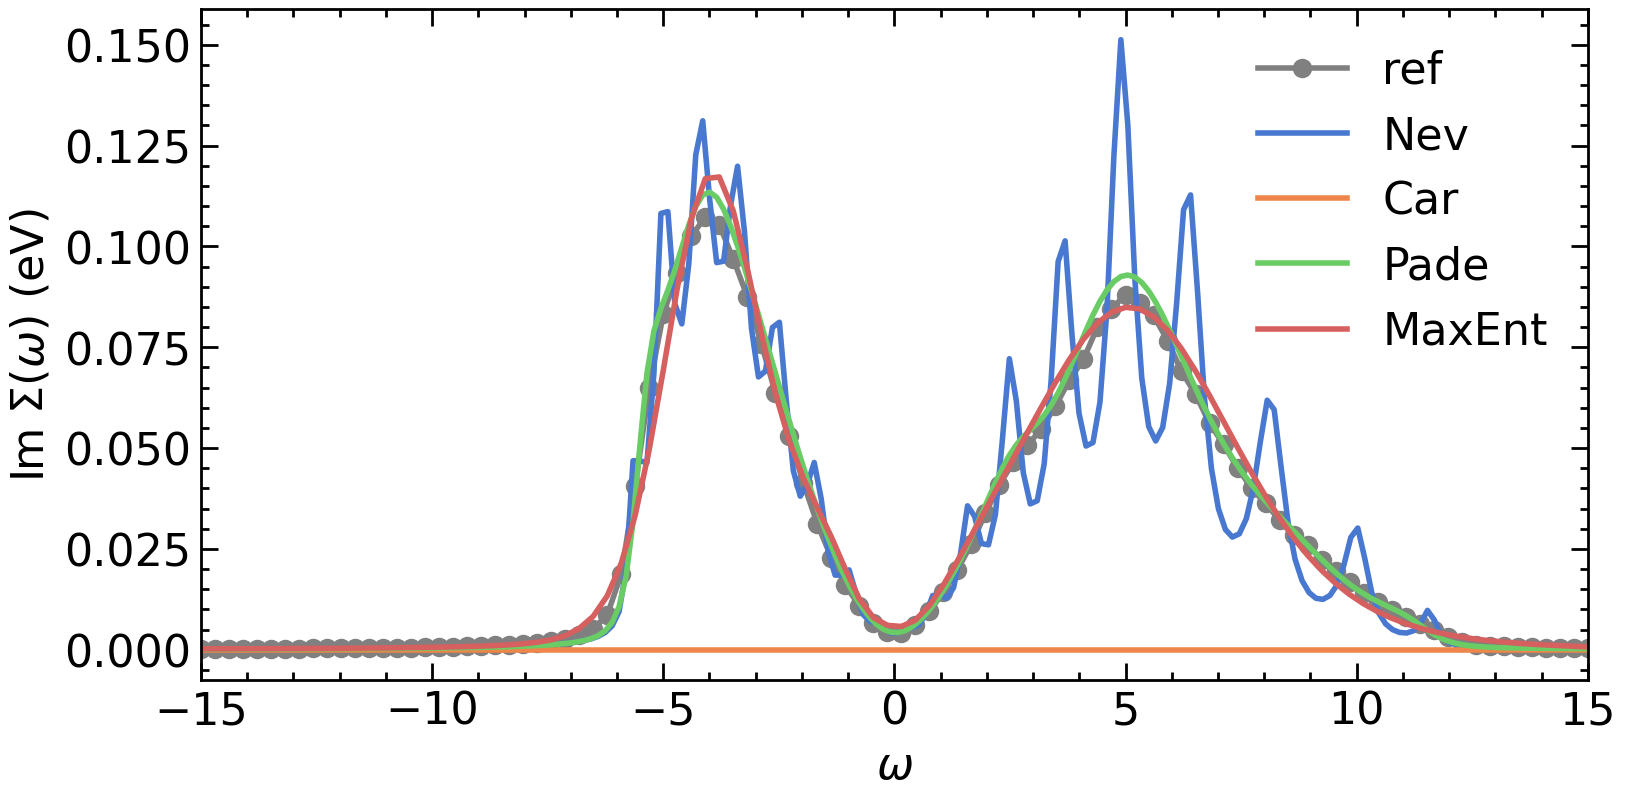

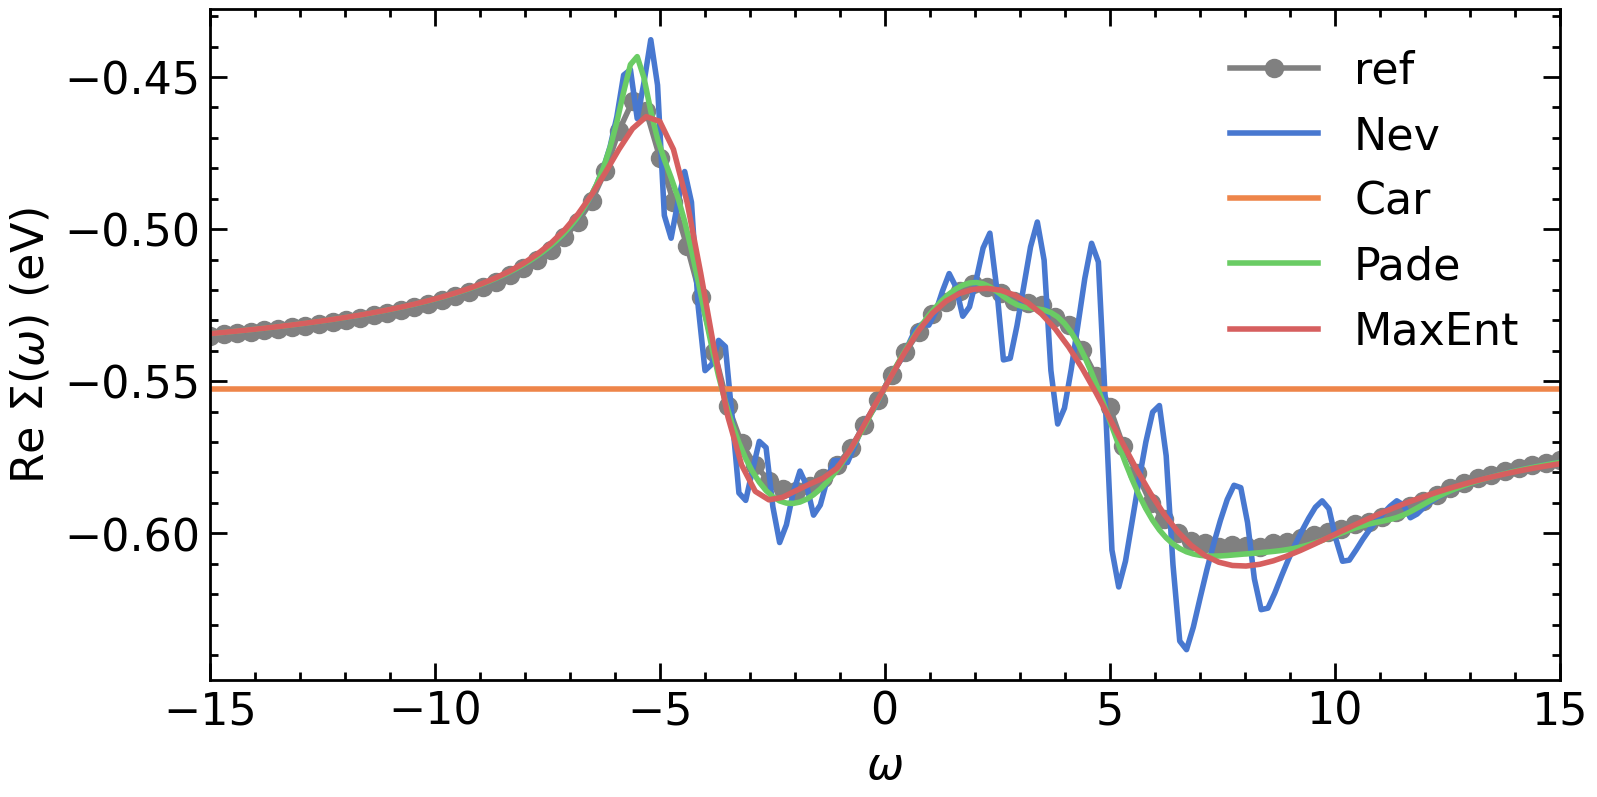

In [20]:
fig, ax = plt.subplots(n_orb, n_orb, figsize=(8*n_orb,4*n_orb), dpi=200, squeeze=False,sharex=True)

shp = Σ_Γ_w.target_shape
for i in range(n_orb):
    for j in range(n_orb):
        # plotting results
        ax[i,j].oplot(Σ_Γ_w[i,j].imag, '-o', c='gray', label=f'ref')
        ax[i,j].oplot(Σ_Γ_w_N[i,j].imag, label=f'Nev')
        ax[i,j].oplot(Σ_Γ_w_CN[i,j].imag, label=f'Car')
        ax[i,j].oplot(Σ_Γ_w_P[i,j].imag, label=f'Pade')
        ax[i,j].oplot(Σ_Γ_w_ME[i,j].imag, label=f'MaxEnt')
        
        
        ax[i,j].set_xlim(GW_window)
        if i == shp[0]-1:
            ax[i,j].set_xlabel(r'$\omega$')
        else:
            ax[i,j].set_xlabel(r'')
        if j == 0:
            ax[i,j].set_ylabel(r'Im $\Sigma (\omega)$ (eV)')
        else:
            ax[i,j].set_ylabel(r'')

plt.tight_layout(pad=0.4, w_pad=0.1, h_pad=0.4)
plt.show()

fig, ax = plt.subplots(n_orb, n_orb, figsize=(8*n_orb,4*n_orb), dpi=200, squeeze=False,sharex=True)

for i in range(n_orb):
    for j in range(n_orb):
        # plotting results
        ax[i,j].oplot(Σ_Γ_w[i,j].real, '-o', c='gray', label=f'ref')
        ax[i,j].oplot(Σ_Γ_w_N[i,j].real, label=f'Nev')
        ax[i,j].oplot((Σ_Γ_w_CN[i,j]+Σ_Γ_iw(Σ_Γ_iw.mesh.last_index())[i,j]).real, label=f'Car')
        ax[i,j].oplot(Σ_Γ_w_P[i,j].real, label=f'Pade')
        ax[i,j].oplot(Σ_Γ_w_ME[i,j].real, label=f'MaxEnt')
        
        ax[i,j].set_xlim(GW_window)
        if i == shp[0]-1:
            ax[i,j].set_xlabel(r'$\omega$')
        else:
            ax[i,j].set_xlabel(r'')
        if j == 0:
            ax[i,j].set_ylabel(r'Re $\Sigma (\omega)$ (eV)')
        else:
            ax[i,j].set_ylabel(r'')

plt.tight_layout(pad=0.4, w_pad=0.1, h_pad=0.4)
plt.show()